In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [2]:
X = train_data.drop(columns=['label'])  
y = train_data['label'] 
X_test = test_data

# Partition data into 80% training and 20% validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [3]:
# Function to compute and plot AUROC curve

def compute_and_plot_AUROC(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [4]:
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

KNN AUROC: 
0.6432111489363206


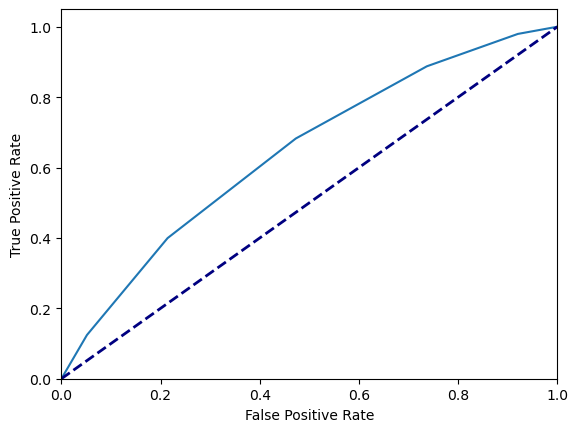

In [5]:
# Train the KNN model 
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_model = knn_model.fit(X_train_scaled, y_train) 
knn_predict = knn_model.predict_proba(X_val_scaled)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_val, knn_predict, pos_label=1)
print("KNN AUROC: ")
print(metrics.auc(fpr, tpr))
compute_and_plot_AUROC(fpr, tpr)

Random Forest AUROC: 
0.7841394161170918


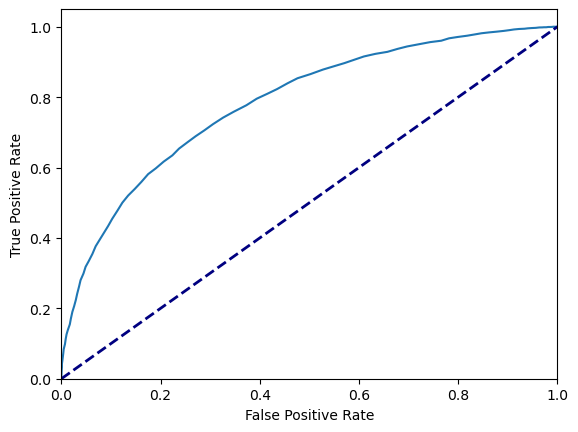

Gradient Boosting AUROC: 
0.7821692691584222


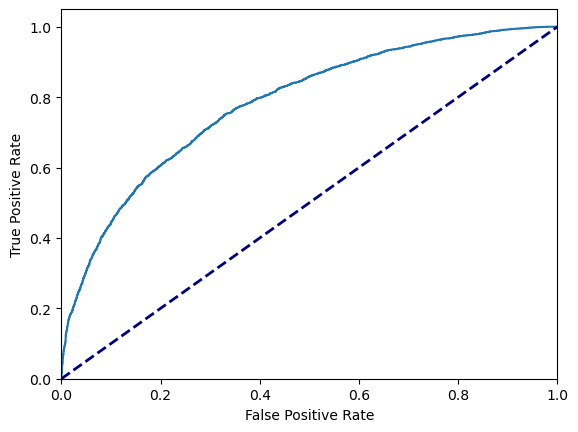

Logistic Regression AUROC: 
0.6745144835917259


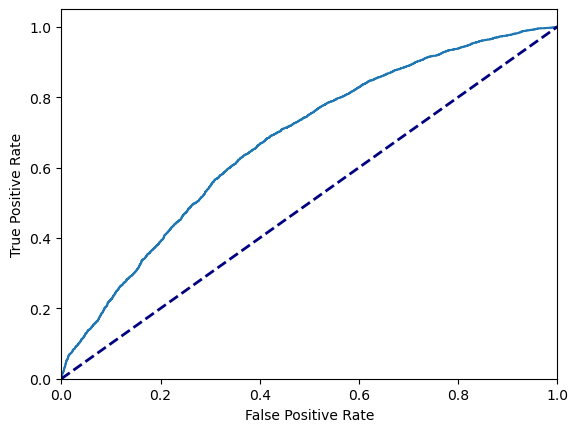

SVM AUROC: 
0.7103860496083623


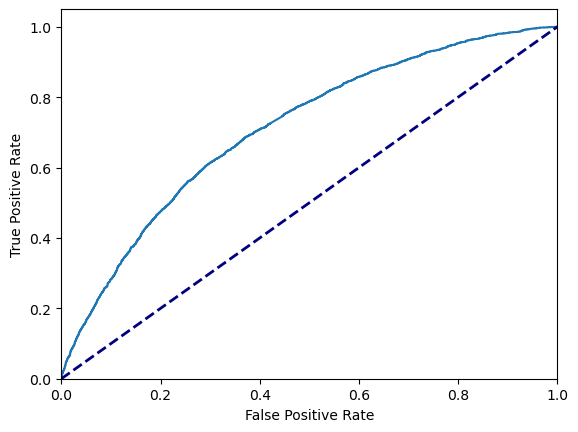

In [6]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred, pos_label=1)
    print(name + " AUROC: ")
    print(metrics.auc(fpr, tpr))
    compute_and_plot_AUROC(fpr, tpr)
    
    results[name] = metrics.auc(fpr, tpr)

The top 3 AUROC scores are for Random Forest (0.784), Gradient Boosting (0.782), and SVM (0.710). 

In [7]:
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

highest_scoring_models = ['Random Forest', 'Gradient Boosting', 'SVM']
filtered_models = {name: models[name] for name in highest_scoring_models}

best_models = {}
best_params = {}

for name, model in filtered_models.items():
    print(f"Hyperparameter tuning: {name}")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, scoring='roc_auc', verbose=1)
    grid_search.fit(X_train, y_train)
 
    best_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_
    print(f"Best Parameters for {name}: {best_params[name]}")

Hyperparameter tuning: Random Forest
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}
Hyperparameter tuning: Gradient Boosting
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Hyperparameter tuning: SVM
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters for SVM: {'C': 10, 'kernel': 'rbf'}


In [13]:
# Test the best models with test data 
random_forest_model = RandomForestClassifier(random_state=42, max_depth=None, min_samples_split=10, n_estimators=300)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict_proba(X_test)[:, 1]

grad_boost_model = GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=5, n_estimators=100)
grad_boost_model.fit(X_train, y_train)
grad_boost_predictions = grad_boost_model.predict_proba(X_test)[:, 1]

svm_model = SVC(probability=True, random_state=42, C=10, kernel='rbf')
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict_proba(X_test)[:,1]


In [9]:
# Random Forest
ids = np.arange(len(random_forest_predictions))
random_forest_submission_data = np.column_stack((ids, random_forest_predictions))

random_forest_submission_data[:, 0] = [f"{x:.18e}" for x in random_forest_submission_data[:, 0]]

# Save submission file
np.savetxt(
    fname='random_forest_submission1.csv',
    X=random_forest_submission_data,
    header='Id,Predicted',
    delimiter=',',
    comments='',
    fmt='%s,%.6f'
)

sub = pd.read_csv(f"./random_forest_submission1.csv")

sub["Predicted"] = random_forest_predictions
sub['Id'] = sub['Id'].astype(np.int64)
sub['Id'] = sub['Id'].apply(lambda x: f"{float(x):.18e}")
sub.to_csv("random_forest_submission2.csv", index=False)

# Gradient Boosting
ids = np.arange(len(grad_boost_predictions))
grad_boost_submission_data = np.column_stack((ids, grad_boost_predictions))

grad_boost_submission_data[:, 0] = [f"{x:.18e}" for x in grad_boost_submission_data[:, 0]]

# Save submission file
np.savetxt(
    fname='grad_boost_submission1.csv',
    X=grad_boost_submission_data,
    header='Id,Predicted',
    delimiter=',',
    comments='',
    fmt='%s,%.6f'
)

sub = pd.read_csv(f"./grad_boost_submission1.csv")

sub["Predicted"] = grad_boost_predictions
sub['Id'] = sub['Id'].astype(np.int64)
sub['Id'] = sub['Id'].apply(lambda x: f"{float(x):.18e}")
sub.to_csv("grad_boost_submission2.csv", index=False)

# SVM
ids = np.arange(len(svm_predictions))
svm_submission_data = np.column_stack((ids, svm_predictions))

svm_submission_data[:, 0] = [f"{x:.18e}" for x in svm_submission_data[:, 0]]

# Save submission file
np.savetxt(
    fname='svm_submission1.csv',
    X=svm_submission_data,
    header='Id,Predicted',
    delimiter=',',
    comments='',
    fmt='%s,%.6f'
)

sub = pd.read_csv(f"./svm_submission1.csv")

sub["Predicted"] = svm_predictions
sub['Id'] = sub['Id'].astype(np.int64)
sub['Id'] = sub['Id'].apply(lambda x: f"{float(x):.18e}")
sub.to_csv("svm_submission2.csv", index=False)
